In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time

# Reading and Running Simulations

In [5]:
file_name = "basic_chemotax.par"
output_file = "data_cellcount_testing.txt"

mcs = 1000
season_experiment = 1
season_duration = 1000

create_config(file_name, {'mcs': mcs,
                          'season_experiment': season_experiment,
                          'season_duration': season_duration, 
                         'keylock_list_filename': '../data/keylock/KL_l24_14_16_g6.dat',
                         'evolsim': 1,
                        'mut_rate': 0.0})

In [6]:
execute_experiment(file_name,0)

In [7]:
all_cells = read_data("data_cellcount_testing.txt")

FileNotFoundError: [Errno 2] No such file or directory: '../data/output/data_cellcount_testing.txt'

## Running simulations based on Latin Parameters

In [5]:
parameter_list = ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']

In [6]:
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [34]:
mcs = 50*1000
num_experiments = 100

In [ ]:
X = run_simulation_latin(parameter_space,num_experiments,0,{'mcs': mcs, 'storage_stride': 10*1000})

# Using Emukit with Simulations

## Create Emukit Model

In [8]:
num_experiments = 5
parameter_list = ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [9]:
file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [10]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files) 
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [27]:
Y = get_rewards(data_files,average_function_over_time(average_distance_between_cells))

In [28]:
emukit_model = get_emukit_model(X,Y,lengthscale=100,variance=10,noise_var=10)

## Plot Gaussian Process Model

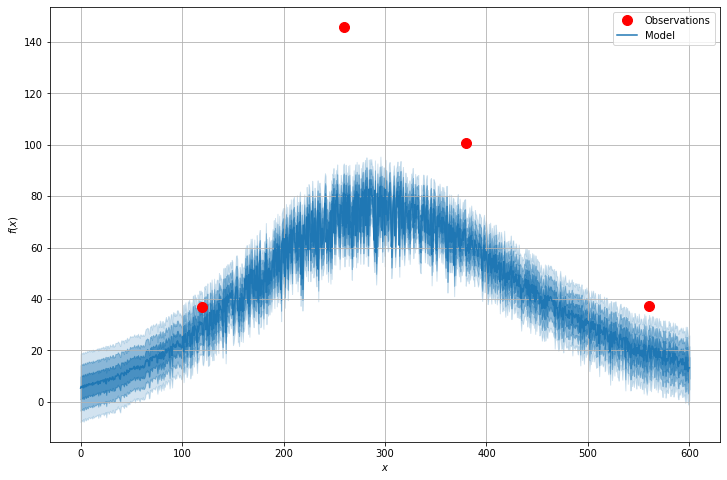

In [29]:
plot_gaussian_process(np.linspace(0,600,1000),0,parameter_space,emukit_model)

## Perform Sensitivity Analysis

In [97]:
get_sobol_indices(emukit_model,parameter_space)

({'season_duration': array([1.00010097]),
  'gamma': array([0.01166655]),
  'mut_rate': array([0.01166655]),
  'T': array([0.01166655]),
  'target_area': array([0.01166655]),
  'gradnoise': array([0.01166655])},
 {'season_duration': array([0.98833345]),
  'gamma': array([-0.08512816]),
  'mut_rate': array([-0.08512816]),
  'T': array([-0.08512816]),
  'target_area': array([-0.08512816]),
  'gradnoise': array([-0.08512816])})